In [1]:
#requirements: pytorch>=1.6.0 numpy tqdm matplotlib
import numpy as np
from tqdm import tqdm
from network import IDreveal
import matplotlib.pyplot as plt

In [2]:
device   = 'cpu' # in ('cpu', 'cuda:0', 'cuda:1')
time     = 100   # length of sequences in frames

ref_vids = [ 'real/vid25fps_caxMBk1__-Y', ] # Reference Videos

test_vids =  [ # Test Videos 
    #(Video, Type),
    ('real/vid25fps_Z1JyukEGjb0',  0),
    ('real/vid25fps_GdxofSvTYUI',  0),
    ('real/vid25fps_M0iV5vIABX0',  0),
    ('fake/vid25fps_oLih6bDkmqg',  1),
    ('fake/vid25fps_kqKgCB4hJw4',  1),
    ('fake/vid25fps_dh-QM54RuAs',  1),
    ('fake/vid25fps_w8sdYZjs-1I',  1),
    ('real/vid25fps_JdA9_mtXYME',  2),
    ('fake/vid25fps_4hMa-gKljhw',  3),
]

typ_colors = ['C2', 'C3', 'C4', 'C6'] # color for each type of video
typ_labels = ['Real videos', 'Deepfakes', 'Imitator', 'Deepfake on the imitator'] # label for each type of video

In [3]:
net = IDreveal(time=time, device=device, weights_file='./model.th')
def extract_embedding(x):
    if isinstance(x, str):
        x = np.load(x) # load 3ddfa features
    
    # insert NAN in the temporal positions where the face is not detected
    ts = int(np.nanmin(x['image_inds']))
    te = int(np.nanmax(x['image_inds'])+1)
    inp = np.full((te-ts, x['3ddfa'].shape[1]), np.nan, dtype=np.float32)
    for i,d in zip(x['image_inds'], x['3ddfa']):
        if np.isfinite(i):
            inp[int(i)-ts] = d
    
    y = net(inp) # apply Temporal ID Network
    y = y[np.all(np.isfinite(y),-1)] # remove NAN positions
    return y

In [4]:
# extract embedded vectors for reference videos
print('Extracting embedded vectors for reference videos', flush=True)
ref_embs = np.concatenate([extract_embedding('./feats/%s.npz' % vid) for vid in tqdm(ref_vids)], 0)
print(flush=True)
print('Number of reference embedded vectors:', len(ref_embs), flush=True)

Extracting embedded vectors for reference videos


100%|██████████| 1/1 [00:55<00:00, 55.40s/it]


Number of reference embedded vectors: 2419


In [5]:
print('Extracting embedded vectors and distance computation for test videos', flush=True)
list_dist = list()
count_embs = 0
for vid, typ in tqdm(test_vids):
    embs = extract_embedding('./feats/%s.npz' % vid) # extract embedded vectors for a test video
    count_embs = count_embs + len(embs)
    dist = np.min(np.sum(np.square(ref_embs[None,:,:]-embs[:,None,:]),-1),-1) # compute distances
    list_dist.append((dist, typ))
print(flush=True)
print('Total number of extracted vectors:', count_embs, flush=True)

Extracting embedded vectors and distance computation for test videos


100%|██████████| 9/9 [05:28<00:00, 36.48s/it]


Total number of extracted vectors: 16190


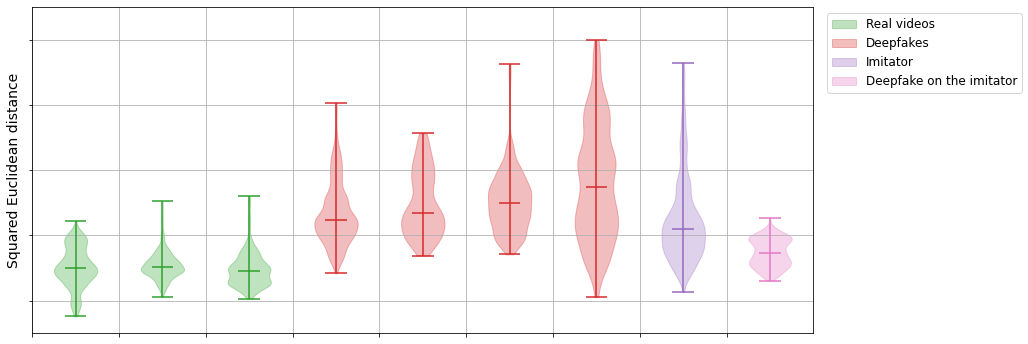

In [6]:
def set_color_violin(parts, color):
    #utlity function to change the color of violin-plot
    ret = None
    for keys in parts:
        if keys=='bodies':
            for pc in parts['bodies']:
                ret = pc
                pc.set_facecolor(color)
                pc.set_edgecolor(color)
        else:
            parts[keys].set_edgecolor(color)
            parts[keys].set_facecolor(color)
    return ret

# show violin-plot
plt.figure(figsize=(14,6))
typ_id = [None for _ in typ_labels]
for i, (dist, typ) in enumerate(list_dist):
    parts = plt.violinplot(dist, positions=(i+0.5,), showmedians=True, points=dist.size)
    typ_id[typ] = set_color_violin(parts, typ_colors[typ])

plt.xlim([0,len(list_dist)])
plt.xticks(np.arange(len(list_dist)),[])
plt.ylim([0.5,5.5])
plt.yticks([1,2,3,4,5],[], fontsize=10.0)
plt.ylabel('Squared Euclidean distance', fontsize=14.0)

plt.legend(typ_id,  typ_labels, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12.0)
plt.grid()
plt.show()    